In [123]:
import FCA, pickle, csv
import numpy as np
import pandas as pd
import networkx as nx
import statistics as s
from math import floor
from NNetwork import NNetwork as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")

import random

from tqdm import trange

In [124]:
def display_graphs(title,
                   save_path,
                   grid_shape=[2,3],
                   fig_size=[10,10],
                   data = None, # [X, embs]
                   show_importance=False):

        # columns of X = vectorized k x k adjacency matrices
        # corresponding list in embs = sequence of nodes (may overalp)
        X, embs = data
        print('X.shape', X.shape)

        rows = grid_shape[0]
        cols = grid_shape[1]

        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        # make outer gridspec

        idx = np.arange(X.shape[1])
        outer_grid = gridspec.GridSpec(nrows=rows, ncols=cols, wspace=0.02, hspace=0.02)

        # make nested gridspecs
        for i in range(rows * cols):
            a = i // cols
            b = i % rows

            Ndict_wspace = 0.05
            Ndict_hspace = 0.05

            # display graphs
            inner_grid = outer_grid[i].subgridspec(1, 1, wspace=Ndict_wspace, hspace=Ndict_hspace)

            # get rid of duplicate nodes
            A = X[:,idx[i]]
            A = X[:,idx[i]].reshape(int(np.sqrt(X.shape[0])), -1)
            H = nn.NNetwork()
            H.read_adj(A, embs[idx[i]])
            A_sub = H.get_adjacency_matrix()

            # read in as a nx graph for plotting
            G1 = nx.from_numpy_matrix(A_sub)
            ax = fig.add_subplot(inner_grid[0, 0])
            pos = nx.spring_layout(G1)
            edges = G1.edges()
            weights = [1*G1[u][v]['weight'] for u,v in edges]
            nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, label='Graph')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.suptitle(title, fontsize=15)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        fig.savefig(save_path, bbox_inches='tight')
        
        


In [125]:
def display_dictionary(W, dictionary_shape=None ,save_name=None, score=None, grid_shape=None, figsize=[10,10]):
    
    if dictionary_shape is None:
        k = int(np.sqrt(W.shape[0]))
        dict_shape = (k,k)
    else:
        dict_shape = dictionary_shape
        
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=figsize
    if (score is None) and (grid_shape is not None):
        figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
        figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(dict_shape), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()
    
    

In [126]:
def display_dict_and_graph(title=None,
                             save_path=None,
                             grid_shape=None,
                             fig_size=[10,10],
                             W = None,
                             At = None,
                             plot_graph_only=False,
                             show_importance=False):
        n_components = W.shape[1]
        k = int(np.sqrt(W.shape[0]))
        rows = np.round(np.sqrt(n_components))
        rows = rows.astype(int)
        if grid_shape is not None:
            rows = grid_shape[0]
            cols = grid_shape[1]
        else:
            if rows ** 2 == n_components:
                cols = rows
            else:
                cols = rows + 1
        if At is None:
            idx = np.arange(W.shape[1])
        else:
            importance = np.sqrt(At.diagonal()) / sum(np.sqrt(At.diagonal()))
            # importance = np.sum(self.code, axis=1) / sum(sum(self.code))
            idx = np.argsort(importance)
            idx = np.flip(idx)
        Ndict_wspace = 0.05
        Ndict_hspace = 0.05
        fig = plt.figure(figsize=fig_size, constrained_layout=False)
        ncols = 2
        if plot_graph_only:
            ncols =1
        outer_grid = gridspec.GridSpec(nrows=1, ncols=ncols, wspace=0.02, hspace=0.05)
        for t in np.arange(ncols):
            # make nested gridspecs
            if t == 1:
                ### Make gridspec
                inner_grid = outer_grid[1].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)
                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    ax.imshow(W.T[idx[i]].reshape(k, k), cmap="gray_r", interpolation='nearest')
                    # ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                    # ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
                    ax.set_xticks([])
                    ax.set_yticks([])
            if t == 0:
                inner_grid = outer_grid[0].subgridspec(rows, cols, wspace=Ndict_wspace, hspace=Ndict_hspace)
                #gs1 = fig.add_gridspec(nrows=rows, ncols=cols, wspace=0.05, hspace=0.05)
                for i in range(rows * cols):
                    a = i // cols
                    b = i % cols
                    ax = fig.add_subplot(inner_grid[a, b])
                    k = int(np.sqrt(W.shape[0]))
                    A_sub = W[:,idx[i]].reshape(k,k)
                    H = nx.from_numpy_matrix(A_sub)
                    G1 = nx.Graph()
                    for a in np.arange(k):
                        for b in np.arange(k):
                            u = list(H.nodes())[a]
                            v = list(H.nodes())[b]
                            if H.has_edge(u,v):
                                if np.abs(a-b) == 1:
                                    G1.add_edge(u,v, color='r', weight=A_sub[a,b])
                                else:
                                    G1.add_edge(u,v, color='b', weight=A_sub[a,b])
                    pos = nx.spring_layout(G1)
                    edges = G1.edges()
                    colors = [G1[u][v]['color'] for u,v in edges]
                    weights = [100*G1[u][v]['weight'] for u,v in edges]
                    nx.draw(G1, with_labels=False, node_size=20, ax=ax, width=weights, edge_color=colors, label='Graph')
                    
                    ## Fix this
                    if show_importance:
                        ax.set_xlabel('%1.2f' % importance[idx[i]], fontsize=13)  # get the largest first
                        ax.xaxis.set_label_coords(0.5, -0.05)  # adjust location of importance appearing beneath patches
#                     ax.set_xticks([])
#                     ax.set_yticks([])
        if title is not None:
            plt.suptitle(title, fontsize=25)
        fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0)
        if save_path is not None:
            fig.savefig(save_path, bbox_inches='tight')
            
            


In [127]:
def coding(X, W, H0, 
          r=None, 
          a1=0, #L1 regularizer
          a2=0, #L2 regularizer
          sub_iter=[5], 
          stopping_grad_ratio=0.0001, 
          nonnegativity=True,
          subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    grad = W.T @ (W @ H0 - X)
    while (i < np.random.choice(sub_iter)):
        step_size = (1 / (((i + 1) ** (1)) * (np.trace(A) + 1)))
        H1 -= step_size * grad 
        if nonnegativity:
            H1 = np.maximum(H1, 0)  # nonnegativity constraint
        i = i + 1
    return H1


def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        # normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        # print('!!! avg entry of X', normalization)
        # X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            # H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, 
            # subsample_ratio=subsample_ratio)
            # W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, 
            # subsample_ratio=subsample_ratio).T
            H = coding(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity,
                       subsample_ratio=subsample_ratio).T
            W /= np.linalg.norm(W)
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H
    

In [128]:
def generate_nxGraphList(X):
    
    graph_list = []
    k = int(np.sqrt(X.shape[0]))
    for i in range(X.shape[1]):
        adj_mat = X.T[i].reshape(k,k)
        G = nx.from_numpy_matrix(adj_mat)
        graph_list.append(G)
    
    return graph_list

### Caltech Network Subsampling Graphs Dictionary Visualization

In [129]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, UCLA26, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'Subgraph_sampling/'

k = 20

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 2500
X.shape (400, 2500)


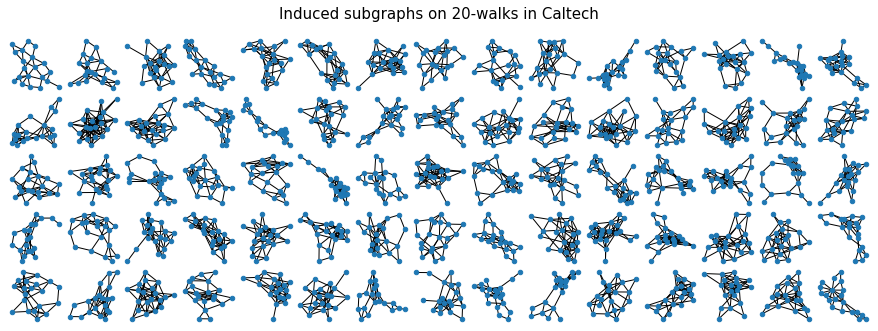

In [130]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [131]:
graph_list = generate_nxGraphList(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [132]:
num_nodes = int(np.sqrt(X.shape[0]))


kappa = 10
FCA_iter = 200

def graphList2AdjMat(graph_list):
    
    df = pd.DataFrame()
    
    for G in graph_list:

        if nx.is_connected(G):

            adj_mat = nx.to_numpy_array(G)
            temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))

            initial_state = np.random.randint(0,kappa,size=num_nodes)

            states, label = FCA.FCA(G, initial_state, kappa, FCA_iter)

            width = FCA.width_compute(states[FCA_iter - 1], kappa)
            y = False
            if (width < floor(kappa / 2)):  # half circle concentration
                y = True

            sync = pd.DataFrame([y], columns=['Synchronized'])

            temp = pd.concat([temp, sync], axis=1)

            df = pd.concat([df, temp], ignore_index=True)


    return df

In [133]:
df = graphList2AdjMat(graph_list);
df.Synchronized.value_counts()

True     2340
False     160
Name: Synchronized, dtype: int64

In [134]:
df.Synchronized.value_counts()

True     2340
False     160
Name: Synchronized, dtype: int64

In [135]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.936


In [136]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T     

W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  1%|▍                                       | 12/1000 [00:00<00:08, 116.07it/s]

iteration 0, reconstruction error 234610.629809
iteration 10, reconstruction error 124481.800065
iteration 20, reconstruction error 113840.788526


  6%|██▍                                     | 62/1000 [00:00<00:05, 156.52it/s]

iteration 30, reconstruction error 106902.616584
iteration 40, reconstruction error 102860.436285
iteration 50, reconstruction error 100548.024003
iteration 60, reconstruction error 99201.054424


 10%|███▊                                    | 95/1000 [00:00<00:05, 160.05it/s]

iteration 70, reconstruction error 98337.043811
iteration 80, reconstruction error 97734.115756
iteration 90, reconstruction error 97282.351421
iteration 100, reconstruction error 96923.987298


 13%|█████                                  | 129/1000 [00:00<00:05, 161.36it/s]

iteration 110, reconstruction error 96627.763226
iteration 120, reconstruction error 96375.738521
iteration 130, reconstruction error 96157.054556
iteration 140, reconstruction error 95965.108674


 18%|███████                                | 181/1000 [00:01<00:05, 160.31it/s]

iteration 150, reconstruction error 95793.145955
iteration 160, reconstruction error 95638.594803
iteration 170, reconstruction error 95499.298202
iteration 180, reconstruction error 95373.042433


 22%|████████▍                              | 216/1000 [00:01<00:04, 165.17it/s]

iteration 190, reconstruction error 95257.424069
iteration 200, reconstruction error 95150.255467
iteration 210, reconstruction error 95050.415057
iteration 220, reconstruction error 94956.497352


 25%|█████████▊                             | 251/1000 [00:01<00:04, 167.59it/s]

iteration 230, reconstruction error 94868.085888
iteration 240, reconstruction error 94784.371343
iteration 250, reconstruction error 94704.870070
iteration 260, reconstruction error 94629.623860


 30%|███████████▉                           | 305/1000 [00:01<00:04, 171.76it/s]

iteration 270, reconstruction error 94558.008862
iteration 280, reconstruction error 94490.012753
iteration 290, reconstruction error 94425.662746
iteration 300, reconstruction error 94364.953640


 34%|█████████████▎                         | 341/1000 [00:02<00:03, 169.36it/s]

iteration 310, reconstruction error 94307.988723
iteration 320, reconstruction error 94254.994931
iteration 330, reconstruction error 94205.652958
iteration 340, reconstruction error 94160.195140


 38%|██████████████▋                        | 376/1000 [00:02<00:03, 170.14it/s]

iteration 350, reconstruction error 94118.524952
iteration 360, reconstruction error 94080.878627
iteration 370, reconstruction error 94047.422749
iteration 380, reconstruction error 94017.573858


 41%|████████████████                       | 412/1000 [00:02<00:03, 171.23it/s]

iteration 390, reconstruction error 93990.969051
iteration 400, reconstruction error 93967.250320
iteration 410, reconstruction error 93946.052304
iteration 420, reconstruction error 93927.031963


 46%|██████████████████▏                    | 465/1000 [00:02<00:03, 169.47it/s]

iteration 430, reconstruction error 93910.115599
iteration 440, reconstruction error 93894.866216
iteration 450, reconstruction error 93881.104173
iteration 460, reconstruction error 93868.699552


 50%|███████████████████▌                   | 501/1000 [00:03<00:02, 170.59it/s]

iteration 470, reconstruction error 93857.399550
iteration 480, reconstruction error 93847.046706
iteration 490, reconstruction error 93837.502459
iteration 500, reconstruction error 93828.647361


 54%|████████████████████▉                  | 537/1000 [00:03<00:02, 171.91it/s]

iteration 510, reconstruction error 93820.366234
iteration 520, reconstruction error 93812.582963
iteration 530, reconstruction error 93805.236388
iteration 540, reconstruction error 93798.269168


 57%|██████████████████████▎                | 573/1000 [00:03<00:02, 170.22it/s]

iteration 550, reconstruction error 93791.629816
iteration 560, reconstruction error 93785.269602
iteration 570, reconstruction error 93779.138966
iteration 580, reconstruction error 93773.214557


 61%|███████████████████████▊               | 609/1000 [00:03<00:02, 169.68it/s]

iteration 590, reconstruction error 93767.487870
iteration 600, reconstruction error 93761.991363
iteration 610, reconstruction error 93756.651191
iteration 620, reconstruction error 93751.422689


 66%|█████████████████████████▊             | 663/1000 [00:03<00:01, 171.40it/s]

iteration 630, reconstruction error 93746.295303
iteration 640, reconstruction error 93741.242345
iteration 650, reconstruction error 93736.250523
iteration 660, reconstruction error 93731.334738


 70%|███████████████████████████▎           | 700/1000 [00:04<00:01, 172.70it/s]

iteration 670, reconstruction error 93726.474245
iteration 680, reconstruction error 93721.650276
iteration 690, reconstruction error 93716.849898
iteration 700, reconstruction error 93712.062676


 74%|████████████████████████████▋          | 736/1000 [00:04<00:01, 171.56it/s]

iteration 710, reconstruction error 93707.295175
iteration 720, reconstruction error 93702.544724
iteration 730, reconstruction error 93697.802267
iteration 740, reconstruction error 93693.053639


 77%|██████████████████████████████         | 772/1000 [00:04<00:01, 170.25it/s]

iteration 750, reconstruction error 93688.273514
iteration 760, reconstruction error 93683.455034
iteration 770, reconstruction error 93678.589302
iteration 780, reconstruction error 93673.667517


 83%|████████████████████████████████▏      | 826/1000 [00:04<00:01, 170.85it/s]

iteration 790, reconstruction error 93668.684316
iteration 800, reconstruction error 93663.631398
iteration 810, reconstruction error 93658.503922
iteration 820, reconstruction error 93653.313210


 86%|█████████████████████████████████▌     | 862/1000 [00:05<00:00, 171.02it/s]

iteration 830, reconstruction error 93648.156808
iteration 840, reconstruction error 93643.047430
iteration 850, reconstruction error 93637.949577
iteration 860, reconstruction error 93632.880057


 90%|███████████████████████████████████    | 898/1000 [00:05<00:00, 171.90it/s]

iteration 870, reconstruction error 93627.949500
iteration 880, reconstruction error 93623.097192
iteration 890, reconstruction error 93618.323353
iteration 900, reconstruction error 93613.631685


 93%|████████████████████████████████████▍  | 934/1000 [00:05<00:00, 171.38it/s]

iteration 910, reconstruction error 93609.031686
iteration 920, reconstruction error 93604.520874
iteration 930, reconstruction error 93600.077699
iteration 940, reconstruction error 93595.678948


 97%|█████████████████████████████████████▊ | 971/1000 [00:05<00:00, 172.36it/s]

iteration 950, reconstruction error 93591.314939
iteration 960, reconstruction error 93586.976287
iteration 970, reconstruction error 93582.653097
iteration 980, reconstruction error 93578.344480


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 167.24it/s]


iteration 990, reconstruction error 93574.065544


###########################
Shape of W_true: (400, 16)
###########################




  9%|███▊                                    | 94/1000 [00:00<00:00, 937.69it/s]

iteration 0, reconstruction error 13676.475684
iteration 10, reconstruction error 6813.545507
iteration 20, reconstruction error 5810.601103
iteration 30, reconstruction error 5346.262429
iteration 40, reconstruction error 5103.719214
iteration 50, reconstruction error 4970.456689
iteration 60, reconstruction error 4888.815700
iteration 70, reconstruction error 4834.758070
iteration 80, reconstruction error 4796.759204
iteration 90, reconstruction error 4769.247172
iteration 100, reconstruction error 4748.721742
iteration 110, reconstruction error 4732.915531
iteration 120, reconstruction error 4720.544064


 20%|███████▋                              | 201/1000 [00:00<00:00, 1013.42it/s]

iteration 130, reconstruction error 4710.813612
iteration 140, reconstruction error 4702.884913
iteration 150, reconstruction error 4696.294500
iteration 160, reconstruction error 4690.618571
iteration 170, reconstruction error 4685.663839
iteration 180, reconstruction error 4681.276256
iteration 190, reconstruction error 4677.255396
iteration 200, reconstruction error 4673.533992


 30%|███████████▌                          | 305/1000 [00:00<00:00, 1023.35it/s]

iteration 210, reconstruction error 4670.089635
iteration 220, reconstruction error 4666.870052
iteration 230, reconstruction error 4663.877065
iteration 240, reconstruction error 4661.091086
iteration 250, reconstruction error 4658.432866
iteration 260, reconstruction error 4655.883841
iteration 270, reconstruction error 4653.421068
iteration 280, reconstruction error 4651.061675
iteration 290, reconstruction error 4648.807654
iteration 300, reconstruction error 4646.654339
iteration 310, reconstruction error 4644.580570
iteration 320, reconstruction error 4642.562558
iteration 330, reconstruction error 4640.592569


 41%|███████████████▌                      | 408/1000 [00:00<00:00, 1023.29it/s]

iteration 340, reconstruction error 4638.666063
iteration 350, reconstruction error 4636.770726
iteration 360, reconstruction error 4634.912564
iteration 370, reconstruction error 4633.106125
iteration 380, reconstruction error 4631.343020
iteration 390, reconstruction error 4629.626633
iteration 400, reconstruction error 4627.953170
iteration 410, reconstruction error 4626.324495


 51%|███████████████████▍                  | 512/1000 [00:00<00:00, 1028.05it/s]

iteration 420, reconstruction error 4624.747333
iteration 430, reconstruction error 4623.220070
iteration 440, reconstruction error 4621.736485
iteration 450, reconstruction error 4620.291266
iteration 460, reconstruction error 4618.890089
iteration 470, reconstruction error 4617.539275
iteration 480, reconstruction error 4616.222385
iteration 490, reconstruction error 4614.937047
iteration 500, reconstruction error 4613.682668
iteration 510, reconstruction error 4612.450674
iteration 520, reconstruction error 4611.266266
iteration 530, reconstruction error 4610.129398
iteration 540, reconstruction error 4609.042379


 62%|███████████████████████▎              | 615/1000 [00:00<00:00, 1019.05it/s]

iteration 550, reconstruction error 4607.986721
iteration 560, reconstruction error 4606.956106
iteration 570, reconstruction error 4605.942535
iteration 580, reconstruction error 4604.943693
iteration 590, reconstruction error 4603.956961
iteration 600, reconstruction error 4602.978177
iteration 610, reconstruction error 4602.020865
iteration 620, reconstruction error 4601.071774


 72%|███████████████████████████▏          | 717/1000 [00:00<00:00, 1000.48it/s]

iteration 630, reconstruction error 4600.127256
iteration 640, reconstruction error 4599.193337
iteration 650, reconstruction error 4598.274715
iteration 660, reconstruction error 4597.364543
iteration 670, reconstruction error 4596.471463
iteration 680, reconstruction error 4595.596824
iteration 690, reconstruction error 4594.736564
iteration 700, reconstruction error 4593.891611
iteration 710, reconstruction error 4593.060484
iteration 720, reconstruction error 4592.242929
iteration 730, reconstruction error 4591.438012
iteration 740, reconstruction error 4590.650131


 82%|███████████████████████████████▏      | 821/1000 [00:00<00:00, 1011.94it/s]

iteration 750, reconstruction error 4589.881388
iteration 760, reconstruction error 4589.130710
iteration 770, reconstruction error 4588.406260
iteration 780, reconstruction error 4587.703213
iteration 790, reconstruction error 4587.020379
iteration 800, reconstruction error 4586.356588
iteration 810, reconstruction error 4585.708994
iteration 820, reconstruction error 4585.078960
iteration 830, reconstruction error 4584.465837


 92%|███████████████████████████████████▉   | 923/1000 [00:00<00:00, 949.98it/s]

iteration 840, reconstruction error 4583.879707
iteration 850, reconstruction error 4583.312067
iteration 860, reconstruction error 4582.763392
iteration 870, reconstruction error 4582.236476
iteration 880, reconstruction error 4581.728488
iteration 890, reconstruction error 4581.236836
iteration 900, reconstruction error 4580.760858
iteration 910, reconstruction error 4580.298745
iteration 920, reconstruction error 4579.849337
iteration 930, reconstruction error 4579.413469


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 992.84it/s]

iteration 940, reconstruction error 4578.990497
iteration 950, reconstruction error 4578.582643
iteration 960, reconstruction error 4578.187327
iteration 970, reconstruction error 4577.804199
iteration 980, reconstruction error 4577.434414
iteration 990, reconstruction error 4577.076253


###########################
Shape of W_false: (400, 16)
###########################




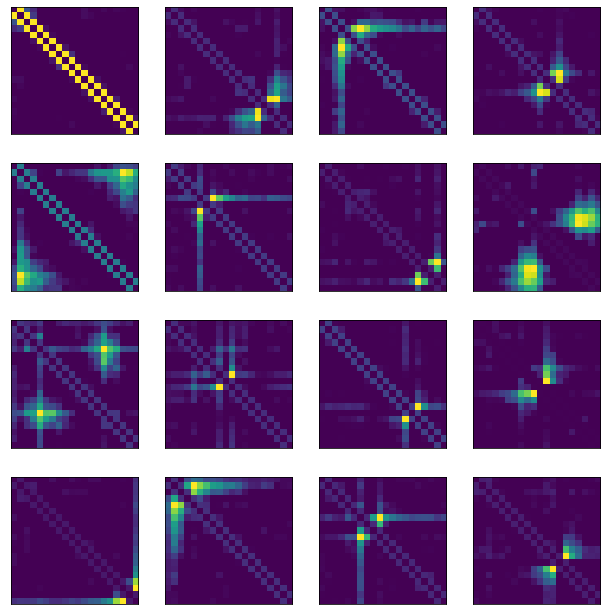

In [137]:

display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_True",
                   figsize = [10,10])

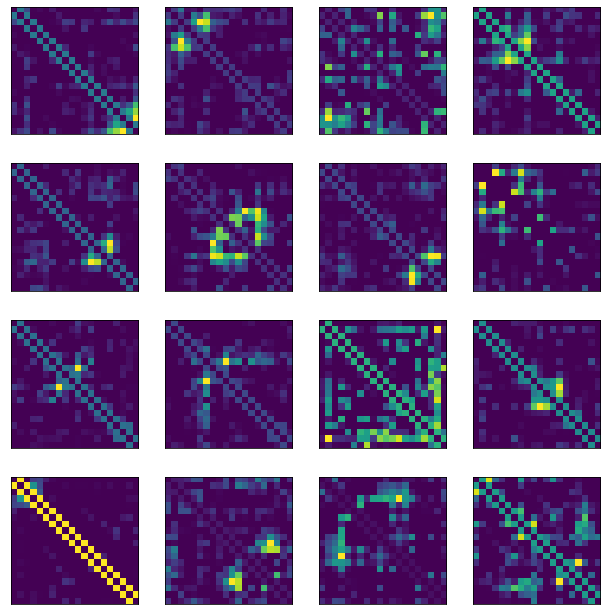

In [138]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_False",
                   figsize = [10,10])

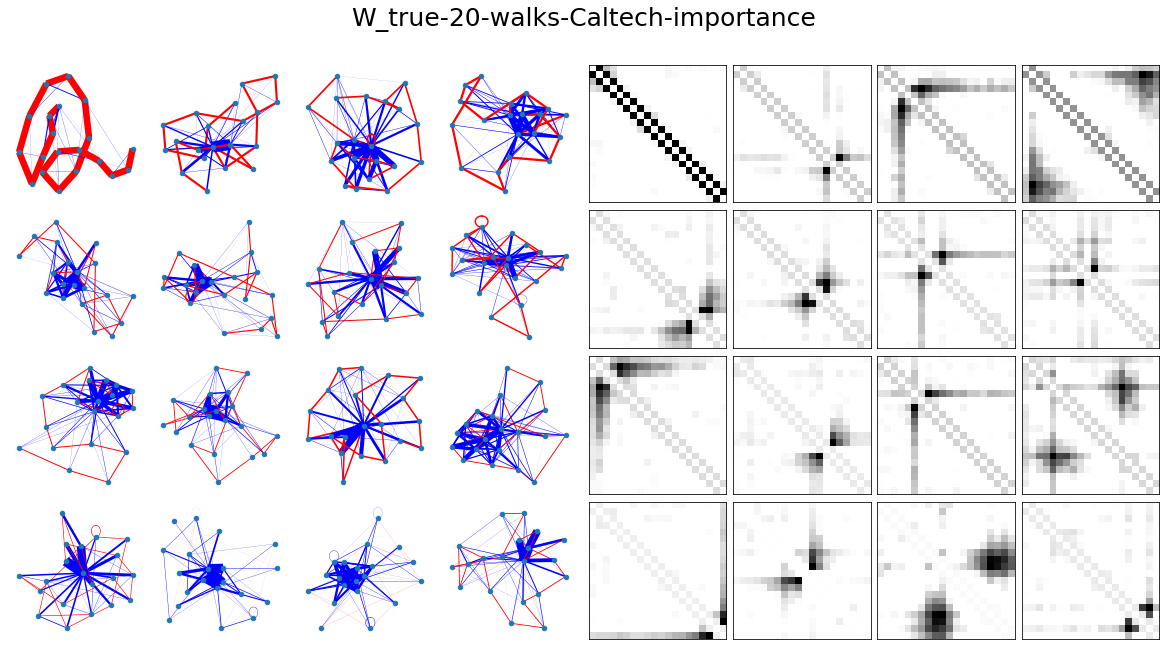

In [139]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

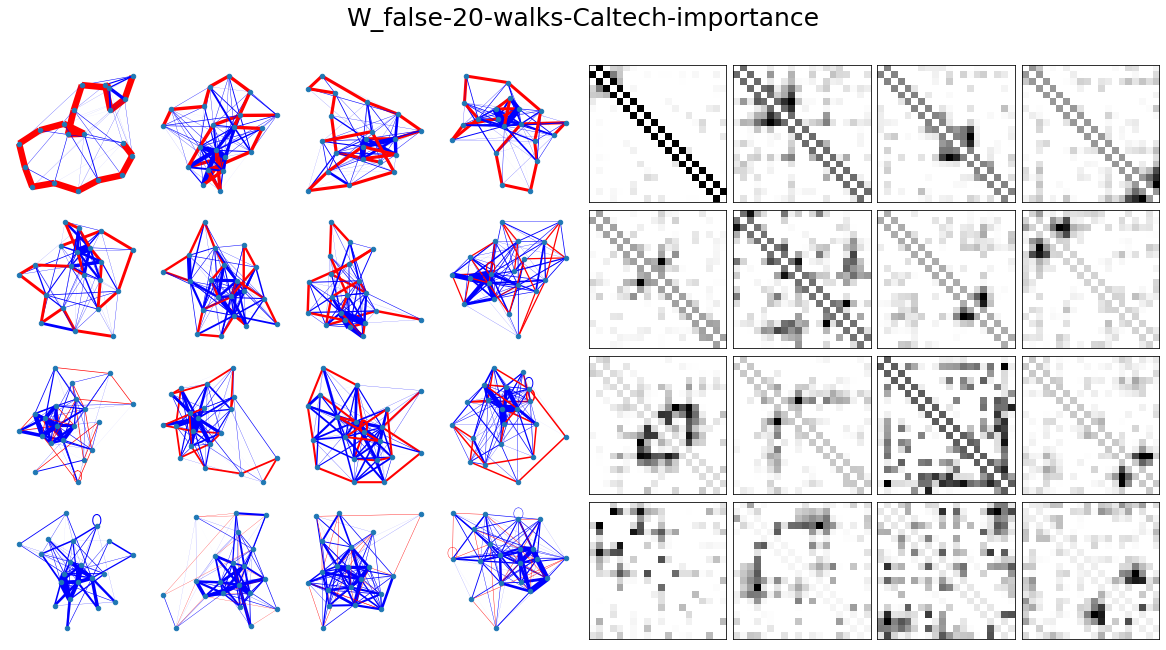

In [140]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

### UCLA Network Subsampling Graphs Dictionary Visualization

In [141]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, UCLA26, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
k = 20

save_folder = 'Subgraph_sampling/'

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 2500
X.shape (400, 2500)


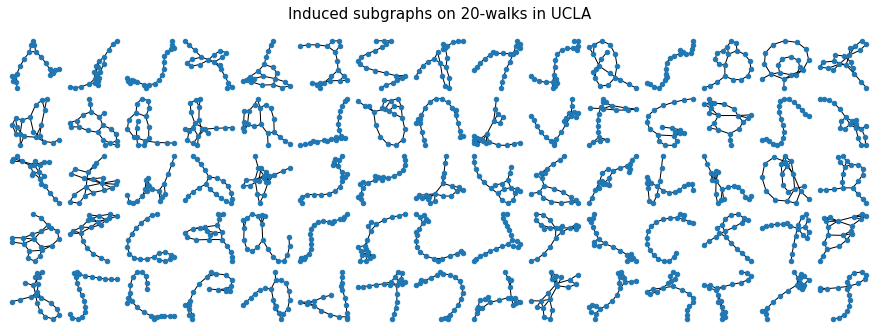

In [142]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [143]:
graph_list = generate_nxGraphList(X)
print(f"num of graphs: {len(graph_list)}")

num_nodes = int(np.sqrt(X.shape[0]))

num of graphs: 2500


In [144]:
df = graphList2AdjMat(graph_list);
df.Synchronized.value_counts()

True     1759
False     741
Name: Synchronized, dtype: int64

In [145]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.7036


In [146]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T     

W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  2%|▋                                       | 17/1000 [00:00<00:05, 165.16it/s]

iteration 0, reconstruction error 91736.120253
iteration 10, reconstruction error 26196.429110
iteration 20, reconstruction error 27502.498628


  4%|█▍                                      | 35/1000 [00:00<00:05, 171.45it/s]

iteration 30, reconstruction error 25058.269901


  5%|██                                      | 53/1000 [00:00<00:05, 172.18it/s]

iteration 40, reconstruction error 21443.864542
iteration 50, reconstruction error 19942.043508
iteration 60, reconstruction error 19115.679705


  7%|██▉                                     | 72/1000 [00:00<00:05, 175.34it/s]

iteration 70, reconstruction error 18440.238211


  9%|███▌                                    | 90/1000 [00:00<00:06, 136.77it/s]

iteration 80, reconstruction error 17858.300065
iteration 90, reconstruction error 17355.663235
iteration 100, reconstruction error 16884.083020


 10%|████                                   | 105/1000 [00:00<00:06, 131.98it/s]

iteration 110, reconstruction error 16445.594542


 14%|█████▍                                 | 141/1000 [00:00<00:05, 152.22it/s]

iteration 120, reconstruction error 16087.220284
iteration 130, reconstruction error 15814.148138
iteration 140, reconstruction error 15611.501989
iteration 150, reconstruction error 15463.455466


 18%|███████                                | 182/1000 [00:01<00:04, 174.47it/s]

iteration 160, reconstruction error 15355.866874
iteration 170, reconstruction error 15277.271885
iteration 180, reconstruction error 15219.186795
iteration 190, reconstruction error 15175.168873
iteration 200, reconstruction error 15140.846372


 22%|████████▋                              | 224/1000 [00:01<00:04, 189.89it/s]

iteration 210, reconstruction error 15113.200087
iteration 220, reconstruction error 15089.901949
iteration 230, reconstruction error 15069.040114
iteration 240, reconstruction error 15049.580605


 25%|█████████▋                             | 247/1000 [00:01<00:03, 200.31it/s]

iteration 250, reconstruction error 15031.004193


 27%|██████████▍                            | 268/1000 [00:01<00:03, 199.59it/s]

iteration 260, reconstruction error 15012.698359
iteration 270, reconstruction error 14994.342258
iteration 280, reconstruction error 14975.728249


 33%|████████████▋                          | 326/1000 [00:01<00:03, 172.65it/s]

iteration 290, reconstruction error 14956.707194
iteration 300, reconstruction error 14937.339485
iteration 310, reconstruction error 14917.704092
iteration 320, reconstruction error 14898.017887


 37%|██████████████▎                        | 367/1000 [00:02<00:03, 185.87it/s]

iteration 330, reconstruction error 14878.664135
iteration 340, reconstruction error 14859.683062
iteration 350, reconstruction error 14841.058052
iteration 360, reconstruction error 14822.748264
iteration 370, reconstruction error 14804.587991


 41%|███████████████▉                       | 409/1000 [00:02<00:03, 196.25it/s]

iteration 380, reconstruction error 14786.271484
iteration 390, reconstruction error 14767.456795
iteration 400, reconstruction error 14747.699393
iteration 410, reconstruction error 14726.645598
iteration 420, reconstruction error 14703.867220


 45%|█████████████████▋                     | 453/1000 [00:02<00:02, 205.10it/s]

iteration 430, reconstruction error 14678.915512
iteration 440, reconstruction error 14651.544925
iteration 450, reconstruction error 14621.649044
iteration 460, reconstruction error 14589.285281
iteration 470, reconstruction error 14554.784784


 52%|████████████████████▎                  | 521/1000 [00:02<00:02, 214.68it/s]

iteration 480, reconstruction error 14518.768007
iteration 490, reconstruction error 14482.148585
iteration 500, reconstruction error 14446.072405
iteration 510, reconstruction error 14411.586991
iteration 520, reconstruction error 14379.592579


 57%|██████████████████████                 | 566/1000 [00:03<00:01, 217.51it/s]

iteration 530, reconstruction error 14350.532418
iteration 540, reconstruction error 14324.576439
iteration 550, reconstruction error 14301.608803
iteration 560, reconstruction error 14281.154737
iteration 570, reconstruction error 14262.905069


 61%|███████████████████████▊               | 610/1000 [00:03<00:01, 212.67it/s]

iteration 580, reconstruction error 14246.620875
iteration 590, reconstruction error 14232.063971
iteration 600, reconstruction error 14219.044073
iteration 610, reconstruction error 14207.408014
iteration 620, reconstruction error 14197.006739


 65%|█████████████████████████▍             | 653/1000 [00:03<00:01, 205.72it/s]

iteration 630, reconstruction error 14187.705458
iteration 640, reconstruction error 14179.348643
iteration 650, reconstruction error 14171.777441
iteration 660, reconstruction error 14164.878415
iteration 670, reconstruction error 14158.584113


 72%|████████████████████████████           | 719/1000 [00:03<00:01, 207.48it/s]

iteration 680, reconstruction error 14152.825949
iteration 690, reconstruction error 14147.542309
iteration 700, reconstruction error 14142.694127
iteration 710, reconstruction error 14138.248398
iteration 720, reconstruction error 14134.170722


 76%|█████████████████████████████▊         | 763/1000 [00:04<00:01, 212.03it/s]

iteration 730, reconstruction error 14130.413525
iteration 740, reconstruction error 14126.944633
iteration 750, reconstruction error 14123.704258
iteration 760, reconstruction error 14120.663659
iteration 770, reconstruction error 14117.803966


 81%|███████████████████████████████▌       | 808/1000 [00:04<00:00, 216.50it/s]

iteration 780, reconstruction error 14115.112051
iteration 790, reconstruction error 14112.570272
iteration 800, reconstruction error 14110.159556
iteration 810, reconstruction error 14107.867079
iteration 820, reconstruction error 14105.683031


 85%|█████████████████████████████████▎     | 854/1000 [00:04<00:00, 218.93it/s]

iteration 830, reconstruction error 14103.598268
iteration 840, reconstruction error 14101.607470
iteration 850, reconstruction error 14099.703686
iteration 860, reconstruction error 14097.879770
iteration 870, reconstruction error 14096.137914


 92%|███████████████████████████████████▉   | 920/1000 [00:04<00:00, 213.19it/s]

iteration 880, reconstruction error 14094.462688
iteration 890, reconstruction error 14092.846960
iteration 900, reconstruction error 14091.289282
iteration 910, reconstruction error 14089.786837
iteration 920, reconstruction error 14088.328924


 94%|████████████████████████████████████▋  | 942/1000 [00:04<00:00, 211.73it/s]

iteration 930, reconstruction error 14086.912982
iteration 940, reconstruction error 14085.542800
iteration 950, reconstruction error 14084.211792


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 190.38it/s]


iteration 960, reconstruction error 14082.914000
iteration 970, reconstruction error 14081.652194
iteration 980, reconstruction error 14080.420641
iteration 990, reconstruction error 14079.216614


###########################
Shape of W_true: (400, 16)
###########################




  0%|                                                  | 0/1000 [00:00<?, ?it/s]

iteration 0, reconstruction error 38183.708567


 12%|████▌                                  | 116/1000 [00:00<00:01, 578.68it/s]

iteration 10, reconstruction error 10871.870593
iteration 20, reconstruction error 12238.703186
iteration 30, reconstruction error 12318.900252
iteration 40, reconstruction error 11484.116672
iteration 50, reconstruction error 9782.358186
iteration 60, reconstruction error 8615.973891
iteration 70, reconstruction error 8226.795143
iteration 80, reconstruction error 7914.676867
iteration 90, reconstruction error 7653.355162
iteration 100, reconstruction error 7431.713283
iteration 110, reconstruction error 7264.419575
iteration 120, reconstruction error 7143.077882


 17%|██████▊                                | 174/1000 [00:00<00:01, 536.40it/s]

iteration 130, reconstruction error 7055.551484
iteration 140, reconstruction error 6989.302098
iteration 150, reconstruction error 6937.268040
iteration 160, reconstruction error 6894.109101
iteration 170, reconstruction error 6856.267809
iteration 180, reconstruction error 6822.009091
iteration 190, reconstruction error 6790.403940
iteration 200, reconstruction error 6761.009871
iteration 210, reconstruction error 6733.470205


 29%|███████████▏                           | 287/1000 [00:00<00:01, 519.58it/s]

iteration 220, reconstruction error 6707.729017
iteration 230, reconstruction error 6683.659396
iteration 240, reconstruction error 6661.424831
iteration 250, reconstruction error 6641.029532
iteration 260, reconstruction error 6622.496816
iteration 270, reconstruction error 6606.059145
iteration 280, reconstruction error 6591.586736
iteration 290, reconstruction error 6578.727064
iteration 300, reconstruction error 6567.208571
iteration 310, reconstruction error 6556.714281
iteration 320, reconstruction error 6547.070847
iteration 330, reconstruction error 6538.007198


 41%|███████████████▊                       | 406/1000 [00:00<00:01, 556.85it/s]

iteration 340, reconstruction error 6529.390572
iteration 350, reconstruction error 6521.007669
iteration 360, reconstruction error 6512.627314
iteration 370, reconstruction error 6504.184528
iteration 380, reconstruction error 6495.660792
iteration 390, reconstruction error 6487.017947
iteration 400, reconstruction error 6478.196428
iteration 410, reconstruction error 6469.091498
iteration 420, reconstruction error 6459.709348
iteration 430, reconstruction error 6449.983915
iteration 440, reconstruction error 6439.868225


 52%|████████████████████▏                  | 518/1000 [00:00<00:00, 523.16it/s]

iteration 450, reconstruction error 6429.333691
iteration 460, reconstruction error 6418.409811
iteration 470, reconstruction error 6407.014928
iteration 480, reconstruction error 6395.182982
iteration 490, reconstruction error 6383.023725
iteration 500, reconstruction error 6370.611932
iteration 510, reconstruction error 6358.017713
iteration 520, reconstruction error 6345.403760
iteration 530, reconstruction error 6332.929616
iteration 540, reconstruction error 6320.693395
iteration 550, reconstruction error 6308.814179


 63%|████████████████████████▍              | 626/1000 [00:01<00:00, 530.49it/s]

iteration 560, reconstruction error 6297.369444
iteration 570, reconstruction error 6286.445428
iteration 580, reconstruction error 6276.121836
iteration 590, reconstruction error 6266.461802
iteration 600, reconstruction error 6257.522048
iteration 610, reconstruction error 6249.325869
iteration 620, reconstruction error 6241.891906
iteration 630, reconstruction error 6235.210774
iteration 640, reconstruction error 6229.236873
iteration 650, reconstruction error 6223.946801
iteration 660, reconstruction error 6219.351394
iteration 670, reconstruction error 6215.364480


 74%|████████████████████████████▊          | 739/1000 [00:01<00:00, 546.04it/s]

iteration 680, reconstruction error 6211.930788
iteration 690, reconstruction error 6208.985758
iteration 700, reconstruction error 6206.451468
iteration 710, reconstruction error 6204.279739
iteration 720, reconstruction error 6202.427562
iteration 730, reconstruction error 6200.838562
iteration 740, reconstruction error 6199.473316
iteration 750, reconstruction error 6198.301230
iteration 760, reconstruction error 6197.296103
iteration 770, reconstruction error 6196.427993
iteration 780, reconstruction error 6195.677034
iteration 790, reconstruction error 6195.024207


 91%|███████████████████████████████████▌   | 911/1000 [00:01<00:00, 562.41it/s]

iteration 800, reconstruction error 6194.456327
iteration 810, reconstruction error 6193.961003
iteration 820, reconstruction error 6193.526339
iteration 830, reconstruction error 6193.141754
iteration 840, reconstruction error 6192.800090
iteration 850, reconstruction error 6192.494373
iteration 860, reconstruction error 6192.219545
iteration 870, reconstruction error 6191.970979
iteration 880, reconstruction error 6191.745101
iteration 890, reconstruction error 6191.539140
iteration 900, reconstruction error 6191.350866
iteration 910, reconstruction error 6191.178467


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 534.76it/s]

iteration 920, reconstruction error 6191.020104
iteration 930, reconstruction error 6190.874630
iteration 940, reconstruction error 6190.740549
iteration 950, reconstruction error 6190.616800
iteration 960, reconstruction error 6190.502351
iteration 970, reconstruction error 6190.396280
iteration 980, reconstruction error 6190.297780
iteration 990, reconstruction error 6190.206170


###########################
Shape of W_false: (400, 16)
###########################




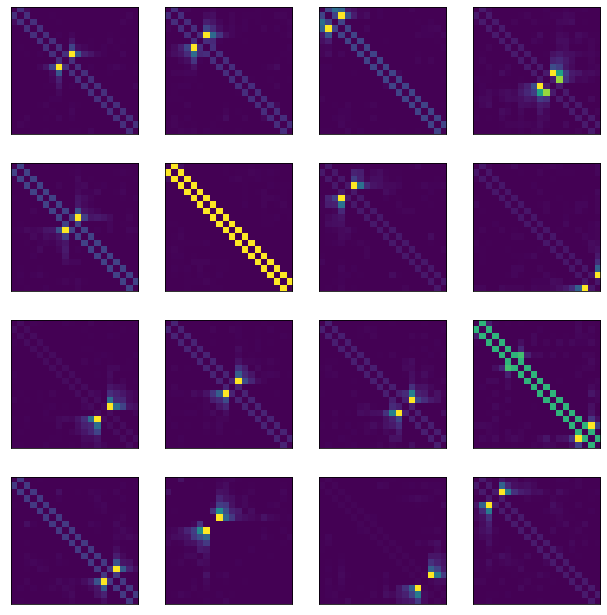

In [147]:
display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_True",
                   figsize = [10,10])

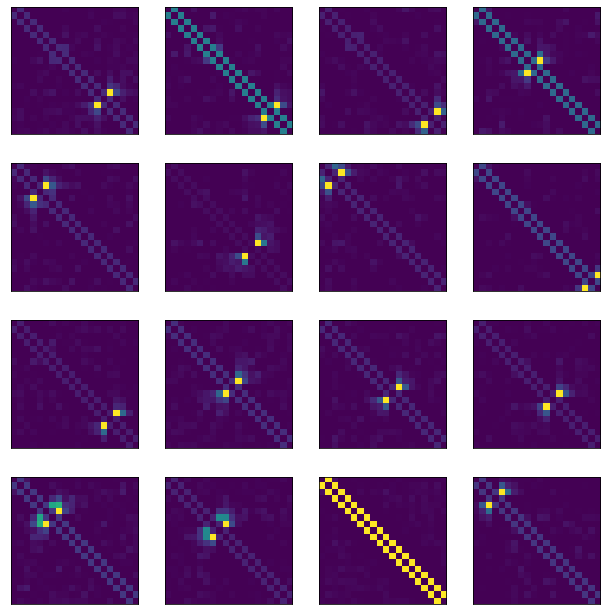

In [148]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_False",
                   figsize = [10,10])

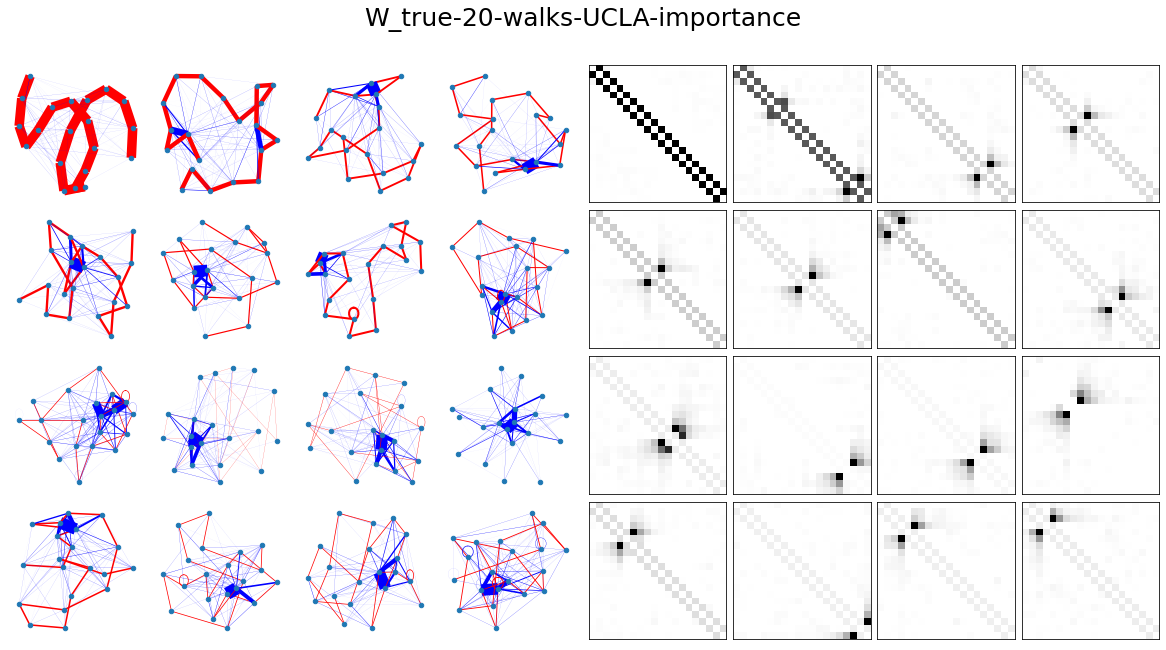

In [149]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

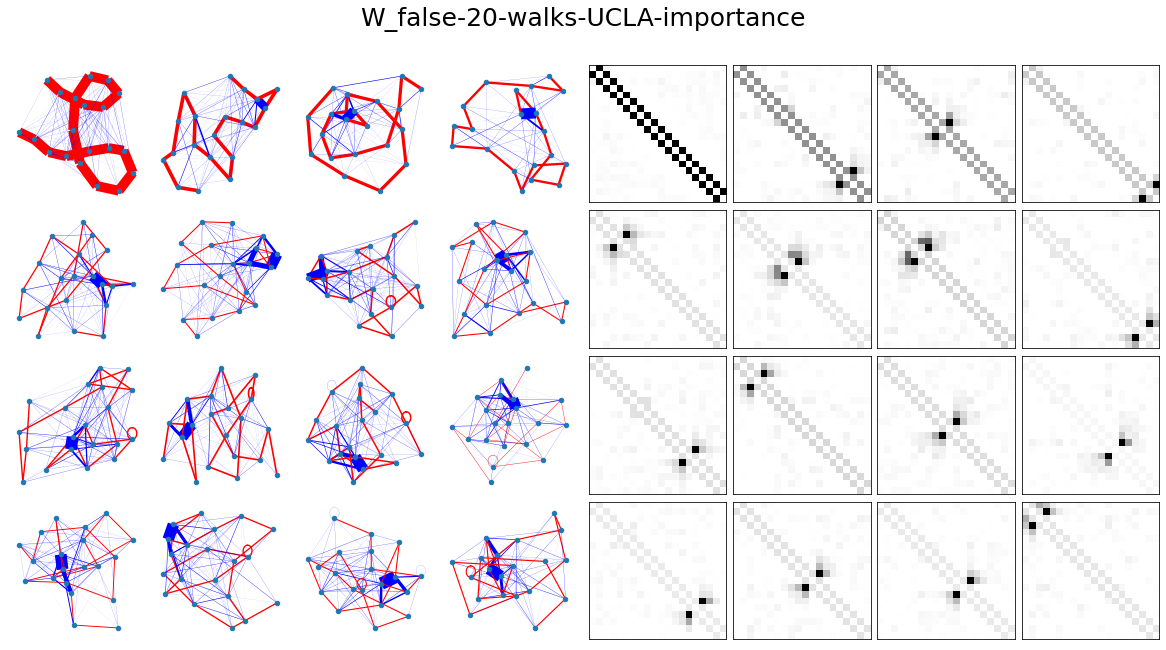

In [150]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

### Wisconsin Network Subsampling Graphs Dictionary Visualization

In [151]:
sampling_alg = 'pivot'

ntwk = 'Wisconsin87' # COVID_PPI, Wisconsin87, UCLA26, Caltech36
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
k = 20

save_folder = 'Subgraph_sampling/'

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 23842
num edges in G 1671904


num of subgraphs induced on k-paths: 2500
X.shape (400, 2500)


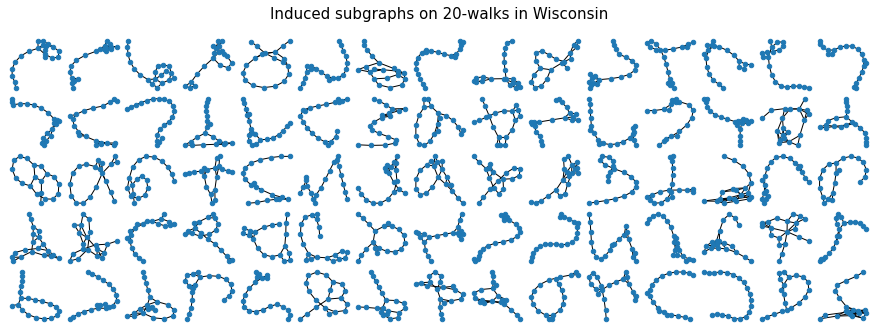

In [152]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [153]:
graph_list = generate_nxGraphList(X)
print(f"num of graphs: {len(graph_list)}")

num_nodes = int(np.sqrt(X.shape[0]))

kappa = 10
FCA_iter = 200

df = graphList2AdjMat(graph_list);
df.Synchronized.value_counts()

num of graphs: 2500


True     1805
False     695
Name: Synchronized, dtype: int64

In [159]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.722


In [154]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T     

W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

% of synchronized cases: 0.722


  2%|▋                                       | 16/1000 [00:00<00:06, 159.98it/s]

iteration 0, reconstruction error 93266.863869
iteration 10, reconstruction error 26001.550373
iteration 20, reconstruction error 27437.185689
iteration 30, reconstruction error 24443.625746


  8%|███                                     | 78/1000 [00:00<00:04, 195.31it/s]

iteration 40, reconstruction error 20717.701871
iteration 50, reconstruction error 19423.615417
iteration 60, reconstruction error 18641.786243
iteration 70, reconstruction error 17942.357859
iteration 80, reconstruction error 17368.964994


 12%|████▋                                  | 119/1000 [00:00<00:04, 198.97it/s]

iteration 90, reconstruction error 16883.127065
iteration 100, reconstruction error 16479.528907
iteration 110, reconstruction error 16170.848850
iteration 120, reconstruction error 15938.762185
iteration 130, reconstruction error 15759.345515


 18%|███████                                | 181/1000 [00:00<00:04, 199.49it/s]

iteration 140, reconstruction error 15615.766077
iteration 150, reconstruction error 15498.517200
iteration 160, reconstruction error 15400.808514
iteration 170, reconstruction error 15318.007301
iteration 180, reconstruction error 15246.727947


 22%|████████▋                              | 222/1000 [00:01<00:03, 199.69it/s]

iteration 190, reconstruction error 15183.778046
iteration 200, reconstruction error 15125.994514
iteration 210, reconstruction error 15070.531746
iteration 220, reconstruction error 15015.912361
iteration 230, reconstruction error 14961.595917


 26%|██████████▏                            | 262/1000 [00:01<00:03, 193.33it/s]

iteration 240, reconstruction error 14907.695799
iteration 250, reconstruction error 14854.402733
iteration 260, reconstruction error 14802.203839
iteration 270, reconstruction error 14751.365773


 30%|███████████▊                           | 302/1000 [00:01<00:03, 195.89it/s]

iteration 280, reconstruction error 14702.540939
iteration 290, reconstruction error 14655.533156
iteration 300, reconstruction error 14610.088629
iteration 310, reconstruction error 14566.281606
iteration 320, reconstruction error 14524.033321


 36%|██████████████▏                        | 365/1000 [00:01<00:03, 204.64it/s]

iteration 330, reconstruction error 14483.379873
iteration 340, reconstruction error 14444.038718
iteration 350, reconstruction error 14405.713035
iteration 360, reconstruction error 14368.101846
iteration 370, reconstruction error 14331.086700


 41%|███████████████▉                       | 408/1000 [00:02<00:02, 207.37it/s]

iteration 380, reconstruction error 14294.292925
iteration 390, reconstruction error 14257.622343
iteration 400, reconstruction error 14221.201773
iteration 410, reconstruction error 14185.307866
iteration 420, reconstruction error 14150.084969


 47%|██████████████████▍                    | 472/1000 [00:02<00:02, 210.37it/s]

iteration 430, reconstruction error 14115.594655
iteration 440, reconstruction error 14081.927774
iteration 450, reconstruction error 14049.315184
iteration 460, reconstruction error 14018.012210
iteration 470, reconstruction error 13988.117671


 52%|████████████████████                   | 516/1000 [00:02<00:02, 210.27it/s]

iteration 480, reconstruction error 13959.610309
iteration 490, reconstruction error 13932.521822
iteration 500, reconstruction error 13906.960910
iteration 510, reconstruction error 13883.058362
iteration 520, reconstruction error 13860.942764


 56%|█████████████████████▊                 | 560/1000 [00:02<00:02, 210.75it/s]

iteration 530, reconstruction error 13840.715373
iteration 540, reconstruction error 13822.405560
iteration 550, reconstruction error 13805.963050
iteration 560, reconstruction error 13791.369842
iteration 570, reconstruction error 13778.598462


 60%|███████████████████████▌               | 603/1000 [00:02<00:01, 207.96it/s]

iteration 580, reconstruction error 13767.426064
iteration 590, reconstruction error 13757.690039
iteration 600, reconstruction error 13749.243975
iteration 610, reconstruction error 13741.924835
iteration 620, reconstruction error 13735.571143


 67%|██████████████████████████             | 668/1000 [00:03<00:01, 197.64it/s]

iteration 630, reconstruction error 13730.003846
iteration 640, reconstruction error 13725.116399
iteration 650, reconstruction error 13720.768615
iteration 660, reconstruction error 13716.875946
iteration 670, reconstruction error 13713.378069


 71%|███████████████████████████▌           | 708/1000 [00:03<00:01, 193.52it/s]

iteration 680, reconstruction error 13710.220395
iteration 690, reconstruction error 13707.359737
iteration 700, reconstruction error 13704.765341
iteration 710, reconstruction error 13702.408319


 75%|█████████████████████████████▎         | 750/1000 [00:03<00:01, 201.26it/s]

iteration 720, reconstruction error 13700.258550
iteration 730, reconstruction error 13698.295504
iteration 740, reconstruction error 13696.501085
iteration 750, reconstruction error 13694.864917
iteration 760, reconstruction error 13693.370949


 79%|██████████████████████████████▉        | 793/1000 [00:03<00:00, 208.10it/s]

iteration 770, reconstruction error 13692.006282
iteration 780, reconstruction error 13690.762445
iteration 790, reconstruction error 13689.627050
iteration 800, reconstruction error 13688.590075
iteration 810, reconstruction error 13687.642769


 86%|█████████████████████████████████▍     | 858/1000 [00:04<00:00, 197.06it/s]

iteration 820, reconstruction error 13686.777227
iteration 830, reconstruction error 13685.986056
iteration 840, reconstruction error 13685.262442
iteration 850, reconstruction error 13684.600603


 88%|██████████████████████████████████▏    | 878/1000 [00:04<00:00, 192.22it/s]

iteration 860, reconstruction error 13683.995421
iteration 870, reconstruction error 13683.442067
iteration 880, reconstruction error 13682.936156
iteration 890, reconstruction error 13682.473051


 94%|████████████████████████████████████▌  | 936/1000 [00:04<00:00, 185.65it/s]

iteration 900, reconstruction error 13682.049234
iteration 910, reconstruction error 13681.661279
iteration 920, reconstruction error 13681.307038
iteration 930, reconstruction error 13680.982875


 98%|██████████████████████████████████████ | 975/1000 [00:04<00:00, 185.00it/s]

iteration 940, reconstruction error 13680.686153
iteration 950, reconstruction error 13680.414228
iteration 960, reconstruction error 13680.164374
iteration 970, reconstruction error 13679.934569


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 197.74it/s]


iteration 980, reconstruction error 13679.723199
iteration 990, reconstruction error 13679.528349


###########################
Shape of W_true: (400, 16)
###########################




  0%|                                                  | 0/1000 [00:00<?, ?it/s]

iteration 0, reconstruction error 34918.132409
iteration 10, reconstruction error 9175.406837
iteration 20, reconstruction error 10507.598892
iteration 30, reconstruction error 10856.373435
iteration 40, reconstruction error 10352.881522
iteration 50, reconstruction error 8943.589023


 11%|████▍                                  | 113/1000 [00:00<00:01, 562.52it/s]

iteration 60, reconstruction error 7389.637913
iteration 70, reconstruction error 6897.509417
iteration 80, reconstruction error 6599.300544
iteration 90, reconstruction error 6394.301932
iteration 100, reconstruction error 6257.583806
iteration 110, reconstruction error 6156.500004
iteration 120, reconstruction error 6070.052292
iteration 130, reconstruction error 5990.843230
iteration 140, reconstruction error 5922.343263
iteration 150, reconstruction error 5866.655721
iteration 160, reconstruction error 5823.247290


 17%|██████▋                                | 170/1000 [00:00<00:01, 536.31it/s]

iteration 170, reconstruction error 5790.279340
iteration 180, reconstruction error 5765.206503
iteration 190, reconstruction error 5745.723667
iteration 200, reconstruction error 5729.947088
iteration 210, reconstruction error 5716.550677
iteration 220, reconstruction error 5704.569710


 22%|████████▋                              | 224/1000 [00:00<00:01, 523.37it/s]

iteration 230, reconstruction error 5693.394973
iteration 240, reconstruction error 5682.555139
iteration 250, reconstruction error 5671.715058
iteration 260, reconstruction error 5660.681584
iteration 270, reconstruction error 5649.434963


 33%|████████████▊                          | 329/1000 [00:00<00:01, 506.81it/s]

iteration 280, reconstruction error 5637.924259
iteration 290, reconstruction error 5626.149862
iteration 300, reconstruction error 5614.095798
iteration 310, reconstruction error 5601.899236
iteration 320, reconstruction error 5589.794706


 38%|██████████████▊                        | 380/1000 [00:00<00:01, 496.43it/s]

iteration 330, reconstruction error 5578.079564
iteration 340, reconstruction error 5566.982920
iteration 350, reconstruction error 5556.649776
iteration 360, reconstruction error 5547.096253
iteration 370, reconstruction error 5538.400605
iteration 380, reconstruction error 5530.489085
iteration 390, reconstruction error 5523.355260
iteration 400, reconstruction error 5516.946045
iteration 410, reconstruction error 5511.153267
iteration 420, reconstruction error 5505.908570


 48%|██████████████████▊                    | 482/1000 [00:00<00:01, 499.05it/s]

iteration 430, reconstruction error 5501.111867
iteration 440, reconstruction error 5496.684522
iteration 450, reconstruction error 5492.527432
iteration 460, reconstruction error 5488.578898
iteration 470, reconstruction error 5484.790325
iteration 480, reconstruction error 5481.118291
iteration 490, reconstruction error 5477.531252
iteration 500, reconstruction error 5474.009414
iteration 510, reconstruction error 5470.528285
iteration 520, reconstruction error 5467.076326
iteration 530, reconstruction error 5463.645933


 58%|██████████████████████▋                | 582/1000 [00:01<00:00, 493.16it/s]

iteration 540, reconstruction error 5460.231698
iteration 550, reconstruction error 5456.841130
iteration 560, reconstruction error 5453.472478
iteration 570, reconstruction error 5450.127832
iteration 580, reconstruction error 5446.818507


 63%|████████████████████████▋              | 632/1000 [00:01<00:00, 494.65it/s]

iteration 590, reconstruction error 5443.552764
iteration 600, reconstruction error 5440.336173
iteration 610, reconstruction error 5437.186177
iteration 620, reconstruction error 5434.127596
iteration 630, reconstruction error 5431.167800
iteration 640, reconstruction error 5428.301624


 68%|██████████████████████████▌            | 682/1000 [00:01<00:00, 494.00it/s]

iteration 650, reconstruction error 5425.536902
iteration 660, reconstruction error 5422.882703
iteration 670, reconstruction error 5420.337090
iteration 680, reconstruction error 5417.896566


 73%|████████████████████████████▌          | 732/1000 [00:01<00:00, 493.51it/s]

iteration 690, reconstruction error 5415.568648
iteration 700, reconstruction error 5413.344403
iteration 710, reconstruction error 5411.212262
iteration 720, reconstruction error 5409.156113
iteration 730, reconstruction error 5407.163635
iteration 740, reconstruction error 5405.225298


 78%|██████████████████████████████▍        | 782/1000 [00:01<00:00, 487.84it/s]

iteration 750, reconstruction error 5403.332543
iteration 760, reconstruction error 5401.479160
iteration 770, reconstruction error 5399.651181
iteration 780, reconstruction error 5397.829410


 83%|████████████████████████████████▍      | 831/1000 [00:01<00:00, 482.68it/s]

iteration 790, reconstruction error 5396.008020
iteration 800, reconstruction error 5394.162687
iteration 810, reconstruction error 5392.272522
iteration 820, reconstruction error 5390.318172
iteration 830, reconstruction error 5388.290264
iteration 840, reconstruction error 5386.169967


 88%|██████████████████████████████████▎    | 881/1000 [00:01<00:00, 487.66it/s]

iteration 850, reconstruction error 5383.930666
iteration 860, reconstruction error 5381.544460
iteration 870, reconstruction error 5378.999075
iteration 880, reconstruction error 5376.273452
iteration 890, reconstruction error 5373.361334


 93%|████████████████████████████████████▎  | 932/1000 [00:01<00:00, 491.52it/s]

iteration 900, reconstruction error 5370.238491
iteration 910, reconstruction error 5366.920323
iteration 920, reconstruction error 5363.397584
iteration 930, reconstruction error 5359.656085
iteration 940, reconstruction error 5355.680235
iteration 950, reconstruction error 5351.480629


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 500.10it/s]

iteration 960, reconstruction error 5347.066070
iteration 970, reconstruction error 5342.429492
iteration 980, reconstruction error 5337.574318
iteration 990, reconstruction error 5332.538830


###########################
Shape of W_false: (400, 16)
###########################




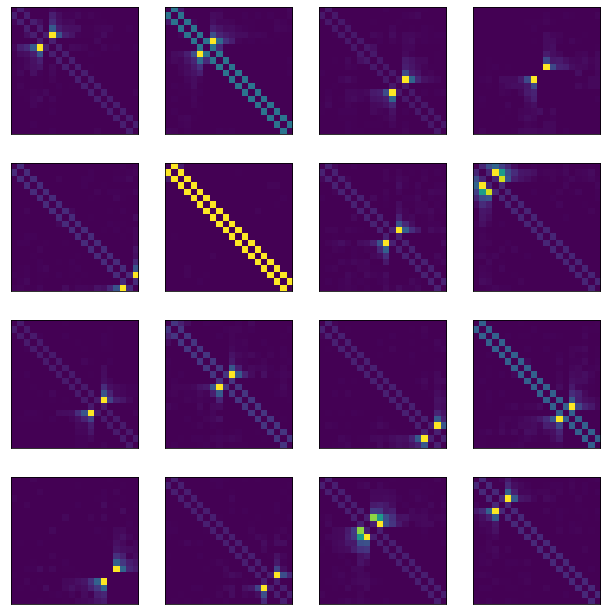

In [155]:
display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_True",
                   figsize = [10,10])

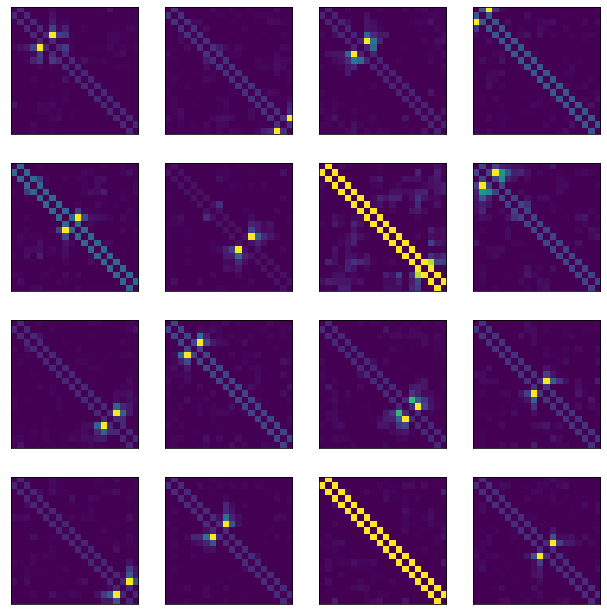

In [156]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_AdjMat_Dictionary_False",
                   figsize = [10,10])

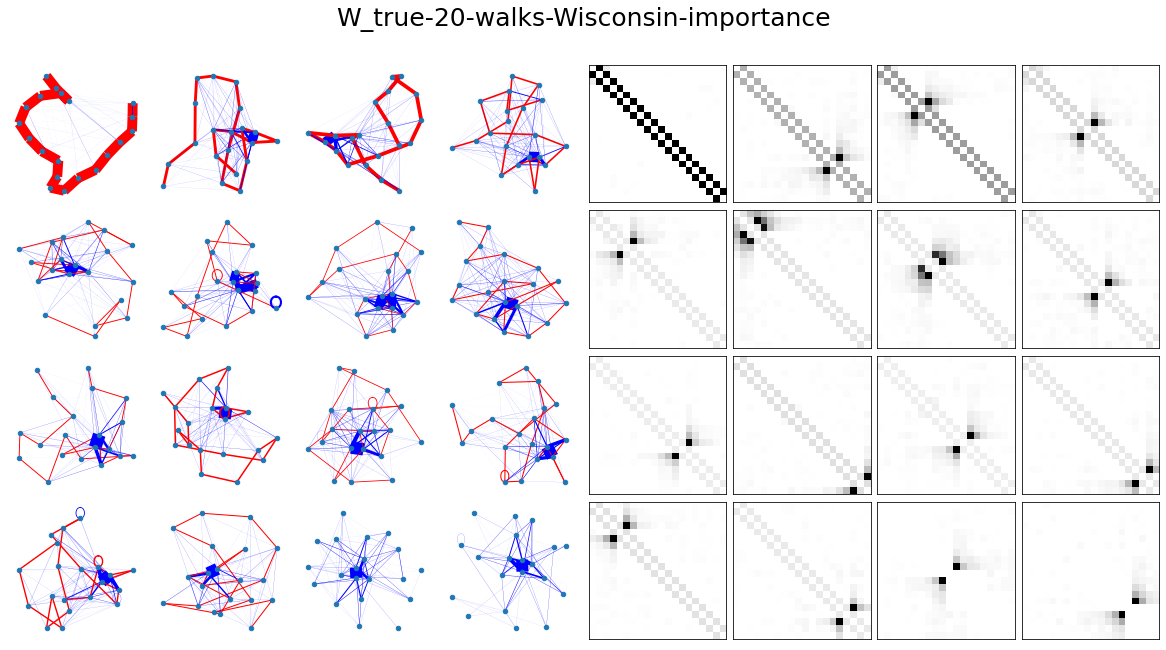

In [157]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

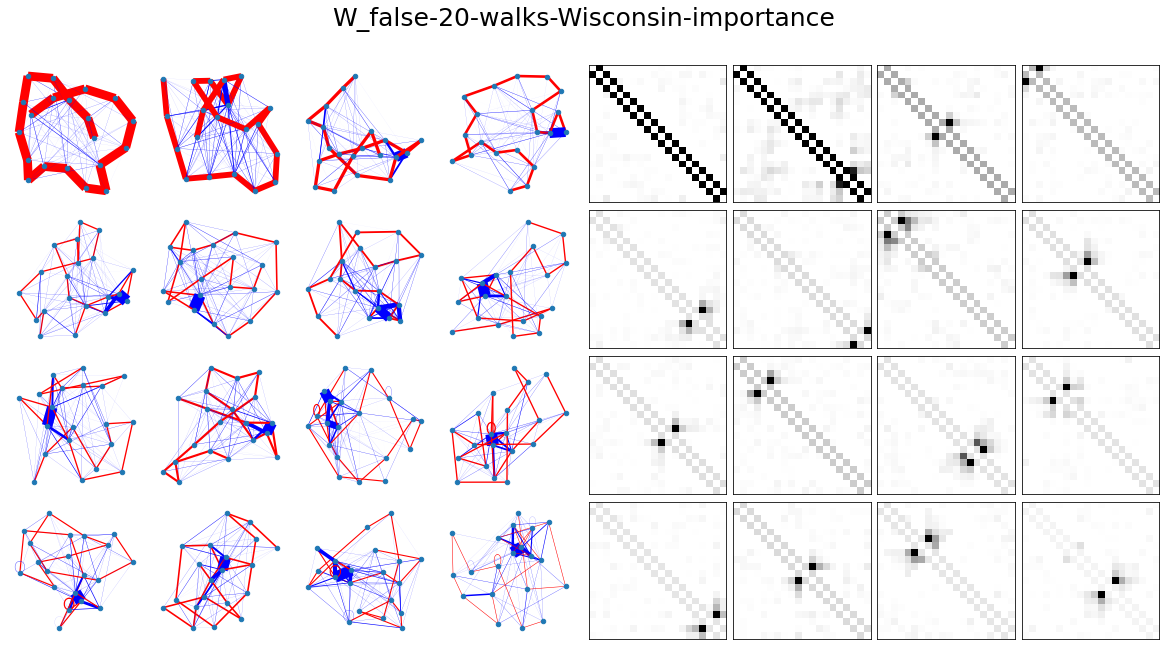

In [158]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

### Test on subgraphs iterates based on Kuramoto:

In [1]:
from kuramoto.nmf import *

In [29]:
sampling_alg = 'pivot'

ntwk = 'Wisconsin87' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'Subgraph_sampling/Kuramoto_Graphs/'
k = 20

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 23842
num edges in G 1671904


num of subgraphs induced on k-paths: 2500
X.shape (400, 2500)


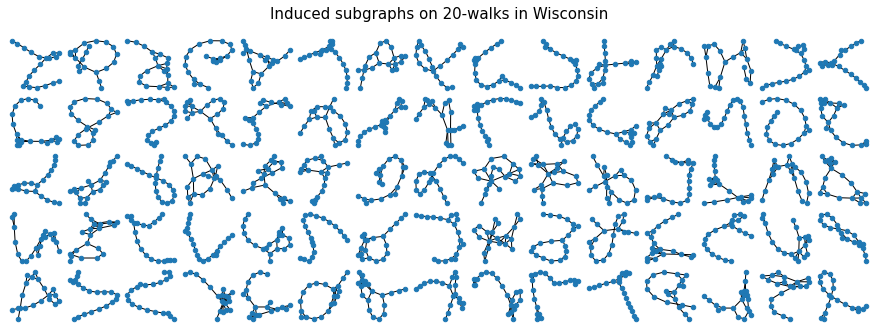

In [30]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [31]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [32]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 2.75

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
2496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
2498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False


In [33]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.2328


In [34]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  6%|██▌                                     | 65/1000 [00:00<00:01, 642.36it/s]

iteration 0, reconstruction error 31450.799194
iteration 10, reconstruction error 9817.312810
iteration 20, reconstruction error 10052.831804
iteration 30, reconstruction error 9044.299772
iteration 40, reconstruction error 7842.348367
iteration 50, reconstruction error 7367.818437
iteration 60, reconstruction error 7032.269405
iteration 70, reconstruction error 6776.922604
iteration 80, reconstruction error 6609.115005
iteration 90, reconstruction error 6488.341011
iteration 100, reconstruction error 6385.581141
iteration 110, reconstruction error 6290.801287
iteration 120, reconstruction error 6204.329626


 14%|█████▎                                 | 135/1000 [00:00<00:01, 669.95it/s]

iteration 130, reconstruction error 6129.879134


 20%|███████▉                               | 202/1000 [00:00<00:01, 667.37it/s]

iteration 140, reconstruction error 6069.209869
iteration 150, reconstruction error 6020.729388
iteration 160, reconstruction error 5981.754002
iteration 170, reconstruction error 5949.069220
iteration 180, reconstruction error 5920.502849
iteration 190, reconstruction error 5894.471856
iteration 200, reconstruction error 5869.827257
iteration 210, reconstruction error 5846.354909
iteration 220, reconstruction error 5824.170973
iteration 230, reconstruction error 5803.452456
iteration 240, reconstruction error 5784.628260
iteration 250, reconstruction error 5767.707760
iteration 260, reconstruction error 5752.505816


 27%|██████████▋                            | 273/1000 [00:00<00:01, 683.15it/s]

iteration 270, reconstruction error 5738.992357
iteration 280, reconstruction error 5726.982670


 34%|█████████████▍                         | 345/1000 [00:00<00:00, 696.26it/s]

iteration 290, reconstruction error 5716.265612
iteration 300, reconstruction error 5706.608812
iteration 310, reconstruction error 5697.932414
iteration 320, reconstruction error 5689.936947
iteration 330, reconstruction error 5682.512254
iteration 340, reconstruction error 5675.606027
iteration 350, reconstruction error 5669.152783
iteration 360, reconstruction error 5662.996151
iteration 370, reconstruction error 5656.982687
iteration 380, reconstruction error 5651.092092
iteration 390, reconstruction error 5645.376061
iteration 400, reconstruction error 5639.634716
iteration 410, reconstruction error 5633.815944


 42%|████████████████▎                      | 418/1000 [00:00<00:00, 705.40it/s]

iteration 420, reconstruction error 5627.934775
iteration 430, reconstruction error 5622.053374


 56%|█████████████████████▉                 | 562/1000 [00:00<00:00, 711.70it/s]

iteration 440, reconstruction error 5616.233897
iteration 450, reconstruction error 5610.551374
iteration 460, reconstruction error 5605.077713
iteration 470, reconstruction error 5599.861751
iteration 480, reconstruction error 5594.934295
iteration 490, reconstruction error 5590.343494
iteration 500, reconstruction error 5586.113775
iteration 510, reconstruction error 5582.246596
iteration 520, reconstruction error 5578.751434
iteration 530, reconstruction error 5575.656022
iteration 540, reconstruction error 5572.917268
iteration 550, reconstruction error 5570.504802
iteration 560, reconstruction error 5568.376396
iteration 570, reconstruction error 5566.498216
iteration 580, reconstruction error 5564.849640


 71%|███████████████████████████▌           | 708/1000 [00:01<00:00, 719.51it/s]

iteration 590, reconstruction error 5563.391301
iteration 600, reconstruction error 5562.101698
iteration 610, reconstruction error 5560.952897
iteration 620, reconstruction error 5559.918733
iteration 630, reconstruction error 5558.980967
iteration 640, reconstruction error 5558.127915
iteration 650, reconstruction error 5557.344975
iteration 660, reconstruction error 5556.622505
iteration 670, reconstruction error 5555.953217
iteration 680, reconstruction error 5555.330791
iteration 690, reconstruction error 5554.748470
iteration 700, reconstruction error 5554.200986
iteration 710, reconstruction error 5553.684987
iteration 720, reconstruction error 5553.197444
iteration 730, reconstruction error 5552.735435


 85%|█████████████████████████████████▎     | 853/1000 [00:01<00:00, 716.67it/s]

iteration 740, reconstruction error 5552.296581
iteration 750, reconstruction error 5551.878834
iteration 760, reconstruction error 5551.480259
iteration 770, reconstruction error 5551.099754
iteration 780, reconstruction error 5550.736254
iteration 790, reconstruction error 5550.389503
iteration 800, reconstruction error 5550.058337
iteration 810, reconstruction error 5549.742064
iteration 820, reconstruction error 5549.440071
iteration 830, reconstruction error 5549.151809
iteration 840, reconstruction error 5548.876734
iteration 850, reconstruction error 5548.614123
iteration 860, reconstruction error 5548.363272
iteration 870, reconstruction error 5548.123399
iteration 880, reconstruction error 5547.893982


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 702.68it/s]


iteration 890, reconstruction error 5547.674244
iteration 900, reconstruction error 5547.463506
iteration 910, reconstruction error 5547.260900
iteration 920, reconstruction error 5547.065650
iteration 930, reconstruction error 5546.877408
iteration 940, reconstruction error 5546.695587
iteration 950, reconstruction error 5546.519719
iteration 960, reconstruction error 5546.349550
iteration 970, reconstruction error 5546.184898
iteration 980, reconstruction error 5546.025352
iteration 990, reconstruction error 5545.870651


###########################
Shape of W_true: (400, 16)
###########################




  0%|                                                  | 0/1000 [00:00<?, ?it/s]

iteration 0, reconstruction error 95624.105623


  4%|█▌                                      | 40/1000 [00:00<00:04, 195.44it/s]

iteration 10, reconstruction error 24672.034924
iteration 20, reconstruction error 27968.594613
iteration 30, reconstruction error 27634.363204
iteration 40, reconstruction error 25065.459374


  6%|██▍                                     | 60/1000 [00:00<00:04, 195.58it/s]

iteration 50, reconstruction error 21497.673551
iteration 60, reconstruction error 18744.708567
iteration 70, reconstruction error 17258.756254


  8%|███▏                                    | 80/1000 [00:00<00:04, 190.28it/s]

iteration 80, reconstruction error 16099.396297


 12%|████▋                                  | 120/1000 [00:00<00:04, 192.54it/s]

iteration 90, reconstruction error 15295.603313
iteration 100, reconstruction error 14743.262702
iteration 110, reconstruction error 14355.335504
iteration 120, reconstruction error 14074.736763


 16%|██████▏                                | 160/1000 [00:00<00:04, 194.94it/s]

iteration 130, reconstruction error 13869.389370
iteration 140, reconstruction error 13718.579120
iteration 150, reconstruction error 13604.686298
iteration 160, reconstruction error 13517.154284


 20%|███████▊                               | 200/1000 [00:01<00:04, 195.42it/s]

iteration 170, reconstruction error 13448.697292
iteration 180, reconstruction error 13393.191780
iteration 190, reconstruction error 13346.694278
iteration 200, reconstruction error 13306.650084


 24%|█████████▎                             | 240/1000 [00:01<00:03, 196.04it/s]

iteration 210, reconstruction error 13270.999182
iteration 220, reconstruction error 13238.164025
iteration 230, reconstruction error 13207.682655
iteration 240, reconstruction error 13179.734856


 28%|██████████▉                            | 280/1000 [00:01<00:03, 195.65it/s]

iteration 250, reconstruction error 13154.266245
iteration 260, reconstruction error 13131.285278
iteration 270, reconstruction error 13110.901925
iteration 280, reconstruction error 13093.189252


 32%|████████████▍                          | 320/1000 [00:01<00:03, 195.47it/s]

iteration 290, reconstruction error 13077.680704
iteration 300, reconstruction error 13063.976049
iteration 310, reconstruction error 13051.544181
iteration 320, reconstruction error 13039.932187


 36%|██████████████                         | 360/1000 [00:01<00:03, 194.80it/s]

iteration 330, reconstruction error 13028.761530
iteration 340, reconstruction error 13017.759975
iteration 350, reconstruction error 13006.684971
iteration 360, reconstruction error 12995.234700


 40%|███████████████▌                       | 400/1000 [00:02<00:03, 193.58it/s]

iteration 370, reconstruction error 12983.112963
iteration 380, reconstruction error 12970.144712
iteration 390, reconstruction error 12956.238661
iteration 400, reconstruction error 12941.469534


 44%|█████████████████▏                     | 440/1000 [00:02<00:02, 195.53it/s]

iteration 410, reconstruction error 12925.927717
iteration 420, reconstruction error 12909.609185
iteration 430, reconstruction error 12892.584478
iteration 440, reconstruction error 12875.030200


 48%|██████████████████▋                    | 480/1000 [00:02<00:02, 194.81it/s]

iteration 450, reconstruction error 12857.008689
iteration 460, reconstruction error 12838.567267
iteration 470, reconstruction error 12819.810596
iteration 480, reconstruction error 12800.987584


 52%|████████████████████▎                  | 520/1000 [00:02<00:02, 194.36it/s]

iteration 490, reconstruction error 12782.161342
iteration 500, reconstruction error 12763.527592
iteration 510, reconstruction error 12745.245480
iteration 520, reconstruction error 12727.585669


 56%|█████████████████████▊                 | 560/1000 [00:02<00:02, 194.79it/s]

iteration 530, reconstruction error 12710.899686
iteration 540, reconstruction error 12695.213834
iteration 550, reconstruction error 12680.678783
iteration 560, reconstruction error 12667.281634


 60%|███████████████████████▍               | 600/1000 [00:03<00:02, 195.73it/s]

iteration 570, reconstruction error 12654.980796
iteration 580, reconstruction error 12643.752429
iteration 590, reconstruction error 12633.584416
iteration 600, reconstruction error 12624.415189


 64%|████████████████████████▉              | 640/1000 [00:03<00:01, 195.58it/s]

iteration 610, reconstruction error 12616.192981
iteration 620, reconstruction error 12608.861879
iteration 630, reconstruction error 12602.352190
iteration 640, reconstruction error 12596.589979


 68%|██████████████████████████▌            | 680/1000 [00:03<00:01, 194.19it/s]

iteration 650, reconstruction error 12591.503484
iteration 660, reconstruction error 12587.034654
iteration 670, reconstruction error 12583.107369
iteration 680, reconstruction error 12579.650650


 72%|████████████████████████████           | 720/1000 [00:03<00:01, 195.04it/s]

iteration 690, reconstruction error 12576.603785
iteration 700, reconstruction error 12573.912187
iteration 710, reconstruction error 12571.536907
iteration 720, reconstruction error 12569.458545


 74%|████████████████████████████▊          | 740/1000 [00:03<00:01, 194.53it/s]

iteration 730, reconstruction error 12567.629928
iteration 740, reconstruction error 12566.010022
iteration 750, reconstruction error 12564.565555


 76%|█████████████████████████████▋         | 760/1000 [00:03<00:01, 192.08it/s]

iteration 760, reconstruction error 12563.273321


 78%|██████████████████████████████▍        | 780/1000 [00:04<00:01, 188.71it/s]

iteration 770, reconstruction error 12562.111059
iteration 780, reconstruction error 12561.060690
iteration 790, reconstruction error 12560.108565


 80%|███████████████████████████████▏       | 799/1000 [00:04<00:01, 183.88it/s]

iteration 800, reconstruction error 12559.243172


 82%|███████████████████████████████▉       | 818/1000 [00:04<00:00, 183.39it/s]

iteration 810, reconstruction error 12558.454700
iteration 820, reconstruction error 12557.735150
iteration 830, reconstruction error 12557.075908


 84%|████████████████████████████████▋      | 837/1000 [00:04<00:00, 179.49it/s]

iteration 840, reconstruction error 12556.470536


 88%|██████████████████████████████████▏    | 875/1000 [00:04<00:00, 178.20it/s]

iteration 850, reconstruction error 12555.913454
iteration 860, reconstruction error 12555.399103
iteration 870, reconstruction error 12554.922862
iteration 880, reconstruction error 12554.481116


 92%|███████████████████████████████████▋   | 915/1000 [00:04<00:00, 186.38it/s]

iteration 890, reconstruction error 12554.070805
iteration 900, reconstruction error 12553.689120
iteration 910, reconstruction error 12553.333603
iteration 920, reconstruction error 12553.002054


 96%|█████████████████████████████████████▏ | 955/1000 [00:04<00:00, 190.67it/s]

iteration 930, reconstruction error 12552.692422
iteration 940, reconstruction error 12552.402844
iteration 950, reconstruction error 12552.131711
iteration 960, reconstruction error 12551.877489


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 191.86it/s]

iteration 970, reconstruction error 12551.638797
iteration 980, reconstruction error 12551.414405
iteration 990, reconstruction error 12551.203289


###########################
Shape of W_false: (400, 16)
###########################




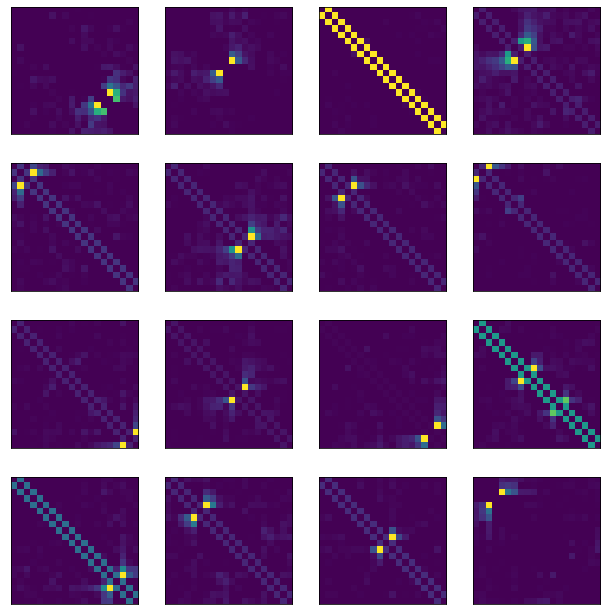

In [35]:
display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_True",
                   figsize = [10,10])

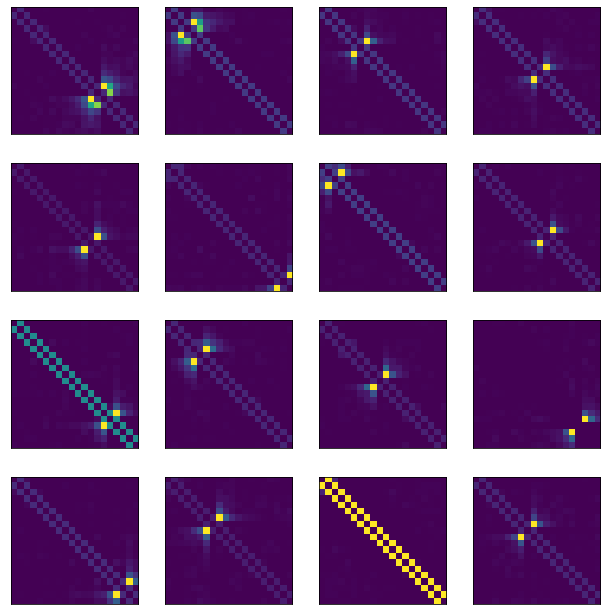

In [36]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_False",
                   figsize = [10,10])

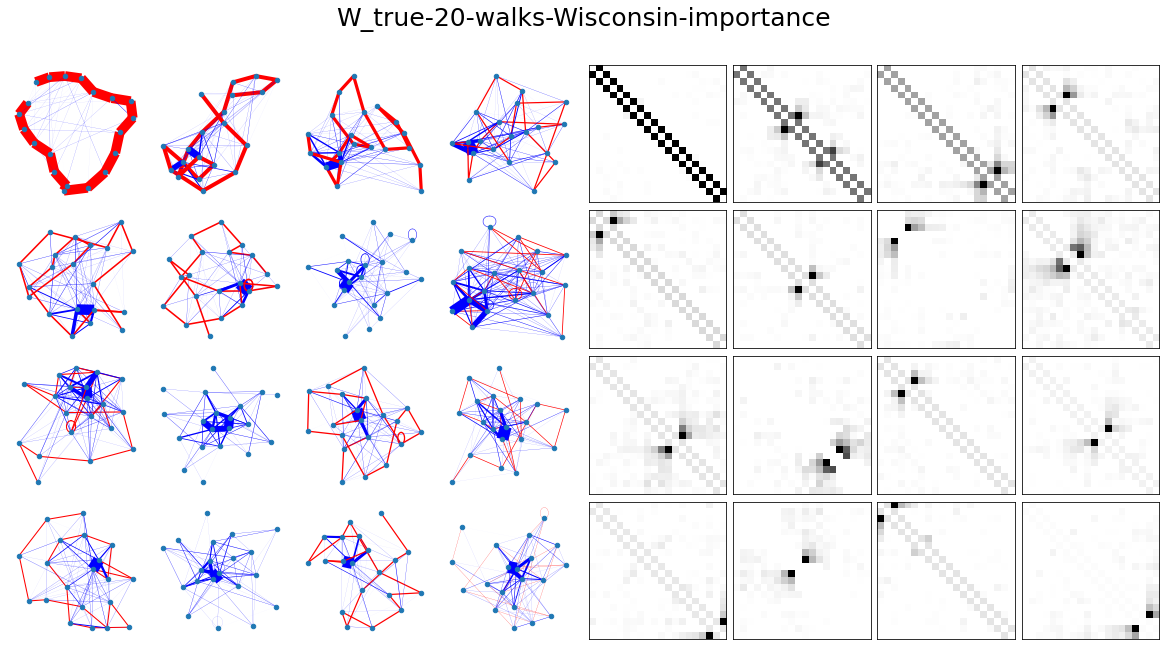

In [37]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

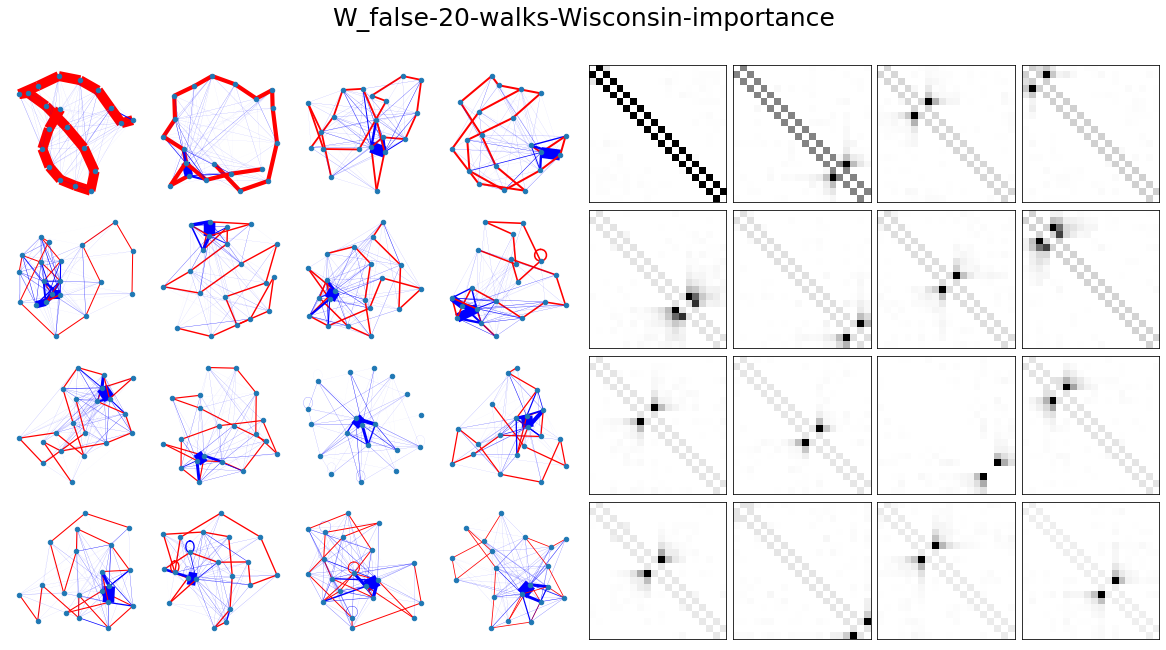

In [38]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)